In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import os

In [2]:
def name_dataset(df, name, embedding_type = None, esm_type = None):
    df['dataset'] = name
    if embedding_type is not None:
        df['embedding_type'] = embedding_type
    if esm_type is not None:
        df['esm_type'] = esm_type
    return df

def left_join_hie(df):
    # Read the file
    comparison = {'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
                  'comparison': [0.22, 0.40, 0.23, 0.16, 0.31, 0.50, 0.077, 0.12, 0.20]}
    comparison = pd.DataFrame(comparison)

    # Merge the two dataframes
    df = pd.merge(df, comparison, on='dataset', how='left')

    return df

def read_data(experiment, grid_search_var, columns_to_collapse, esm="esm2", size_csvs = "t48_15B_UR50D"):
    csvs_file_names_list = ["cov2_S", "cas12f", "zikv_E", "kelsic", "brenan", "stiffler", "markin", "giacomelli", "jones", "haddox", "doud", "lee"]

    all_dfs = []

    for file_name in csvs_file_names_list:
        # Attempt to read the file, and if it doesn't exist, skip to the next iteration
        try:
            file_path = f"../../grid_search/results/{file_name}_{esm}_{size_csvs}_{experiment}_results.csv"
            individual_df = pd.read_csv(file_path)

            # Filter out rows where all columns_to_collapse are None
            individual_df.replace("None", np.nan, inplace=True)
            individual_df = individual_df.dropna(subset=columns_to_collapse, how='all')

            individual_df[columns_to_collapse] = individual_df[columns_to_collapse].apply(pd.to_numeric, errors='coerce')

            # Group by simulation number, grid_search_var, and other columns
            grouped = individual_df.groupby(grid_search_var)

            # Calculate mean and standard deviation for specified columns
            stats = grouped[columns_to_collapse].agg(['mean', 'std'])

            # Flatten multi-index columns
            stats.columns = [f'{col}_{stat}' for col, stat in stats.columns]

            # Reset index to make grouped columns regular columns
            stats.reset_index(inplace=True)

            # Add dataset information
            stats = name_dataset(stats, file_name)

            # Append to list of individual DataFrames
            all_dfs.append(stats)
        except FileNotFoundError:
            print(f"File {file_name}_{esm}_{size_csvs}_{experiment}_results.csv not found. Skipping...")

    # Concatenate all individual DataFrames
    df = pd.concat(all_dfs)

    return df

## One shot comparison

In [3]:
experiment = "one_shot_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_one_shot = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_one_shot.loc[:, 'label'] = "pre-training: " + result_df_one_shot['num_mutants_per_round'].astype(str) + " mutants"

In [4]:
experiment = "esm2_15B_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_rounds = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_rounds_subset = result_df_rounds[result_df_rounds['round_num'].isin([5,10])]
result_df_rounds_subset['label'] = "directed evolution: " + result_df_rounds_subset['round_num'].astype(str) + " rounds"

/tmp/ipykernel_371267/4190193683.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_rounds_subset['label'] = "directed evolution: " + result_df_rounds_subset['round_num'].astype(str) + " rounds"


In [5]:
hie_data = pd.DataFrame({'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
              'fitness_binary_percentage_mean': [0.22, 0.40, 0.23, 0.16, 0.31, 0.50, 0.077, 0.12, 0.20],
              'label': ['efficient-evolution'] * 9  # Add 'additional' label for the new rows
             })
background = pd.DataFrame({'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
              'fitness_binary_percentage_mean': [0.12, 0.079, 0.058, 0.06, 0.066, 0.22, 0.011, 0.12, 0.034],
              'label': ['background'] * 9  # Add 'additional' label for the new rows
             })

In [6]:
hie_data, background

(      dataset  fitness_binary_percentage_mean                label
 0       jones                           0.220  efficient-evolution
 1    stiffler                           0.400  efficient-evolution
 2      haddox                           0.230  efficient-evolution
 3        doud                           0.160  efficient-evolution
 4         lee                           0.310  efficient-evolution
 5      kelsic                           0.500  efficient-evolution
 6      brenan                           0.077  efficient-evolution
 7  giacomelli                           0.120  efficient-evolution
 8      markin                           0.200  efficient-evolution,
       dataset  fitness_binary_percentage_mean       label
 0       jones                           0.120  background
 1    stiffler                           0.079  background
 2      haddox                           0.058  background
 3        doud                           0.060  background
 4         lee          

In [7]:
concatenated_df_one_shot = pd.concat([result_df_rounds_subset, result_df_one_shot, hie_data, background], ignore_index=True)

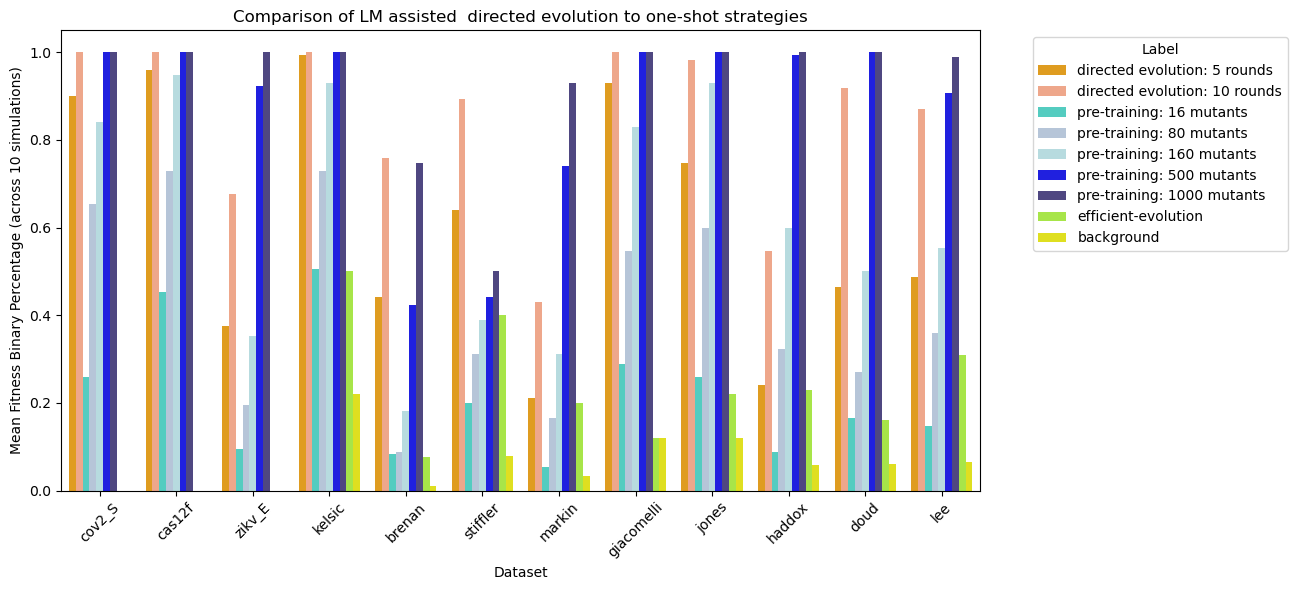

In [8]:
# Define the colors for each hue level
palette_colors = {'efficient-evolution': 'greenyellow', 
                  'background': 'yellow', 
                  
                  'pre-training: 16 mutants': 'turquoise', 
                  'pre-training: 80 mutants': 'lightsteelblue',
                  'pre-training: 160 mutants': 'powderblue',
                  'pre-training: 500 mutants': 'blue',
                  'pre-training: 1000 mutants': 'darkslateblue',

                  'directed evolution: 5 rounds': 'orange',
                  'directed evolution: 10 rounds': 'lightsalmon'}

# Create the bar plot with hue and error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=concatenated_df_one_shot, x='dataset', y='fitness_binary_percentage_mean', hue='label', 
            palette=palette_colors)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

# ax.errorbar(x=x_coords, y=y_coords, yerr=concatenated_df["fitness_binary_percentage_std"], fmt="none", capsize=2, c="k")

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of LM assisted  directed evolution to one-shot strategies')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

concatenated_df_one_shot.to_csv("results/one-shot_results.csv", index=False)

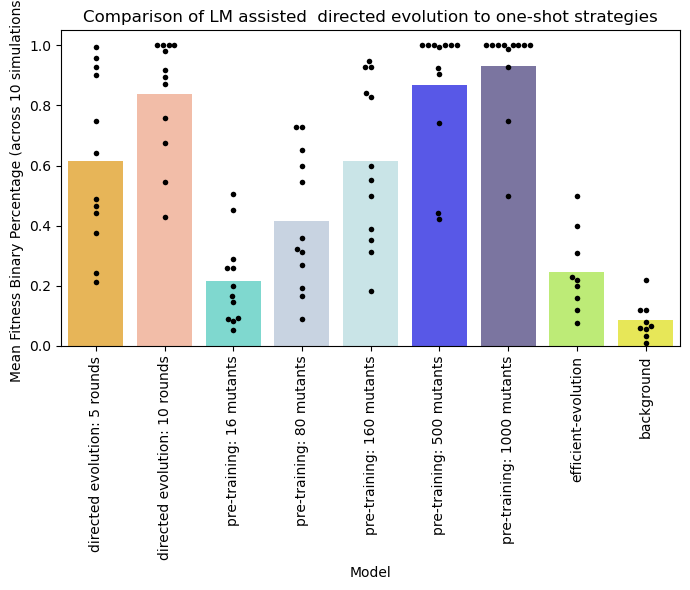

In [9]:
# Define the colors for each hue level
palette_colors = {'efficient-evolution': 'greenyellow', 
                  'background': 'yellow', 
                  
                  'pre-training: 16 mutants': 'turquoise', 
                  'pre-training: 80 mutants': 'lightsteelblue',
                  'pre-training: 160 mutants': 'powderblue',
                  'pre-training: 500 mutants': 'blue',
                  'pre-training: 1000 mutants': 'darkslateblue',

                  'directed evolution: 5 rounds': 'orange',
                  'directed evolution: 10 rounds': 'lightsalmon'}

# Create the bar plot
plt.figure(figsize=(7, 6))
ax = sns.barplot(data=concatenated_df_one_shot, x='label', y='fitness_binary_percentage_mean',
                 palette=palette_colors, errorbar = None, alpha = 0.75)

# Overlay underlying points with jitter
sns.swarmplot(data=concatenated_df_one_shot, x='label', y='fitness_binary_percentage_mean', 
              size=4, color = "black")

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of LM assisted  directed evolution to one-shot strategies')

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



## Multiple round comparison (5,10)

In [10]:
experiment = "esm2_15B_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_15B = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_15B['label'] = "esm2 15B"

In [11]:
experiment = "esm2_3B_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t36_3B_UR50D"

result_df_3B = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_3B['label'] = "esm2 3B"

In [12]:
experiment = "esm2_650M_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t33_650M_UR50D"

result_df_650M = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_650M['label'] = "esm2 650M"

In [13]:
experiment = "esm1b_650M_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm1b"
size_csvs = "t33_650M_UR50S"

result_df_1b_650M = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_1b_650M['label'] = "esm1b 650M"

File cov2_S_esm1b_t33_650M_UR50S_esm1b_650M_average_results.csv not found. Skipping...


In [14]:
experiment = "esm1v_650M_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm1v"
size_csvs = "t33_650M_UR90S_1"

result_df_1v_650M = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_1v_650M['label'] = "esm1v 650M"

File cov2_S_esm1v_t33_650M_UR90S_1_esm1v_650M_average_results.csv not found. Skipping...


In [15]:
experiment = "one-hot_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "one_hot"
size_csvs = "encoded"

result_df_one_hot = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_one_hot['label'] = "one-hot encoded"

In [16]:
experiment = "integer_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "integer"
size_csvs = "encoded"

result_df_integer = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_integer['label'] = "integer encoded"

In [17]:
concatenated_df = pd.concat([result_df_15B, result_df_3B, result_df_650M, result_df_1b_650M, result_df_1v_650M, result_df_one_hot, result_df_integer], ignore_index=True)

concatenated_df_5 = concatenated_df[concatenated_df['round_num'] == 5]
concatenated_df_10 = concatenated_df[concatenated_df['round_num'] == 10]

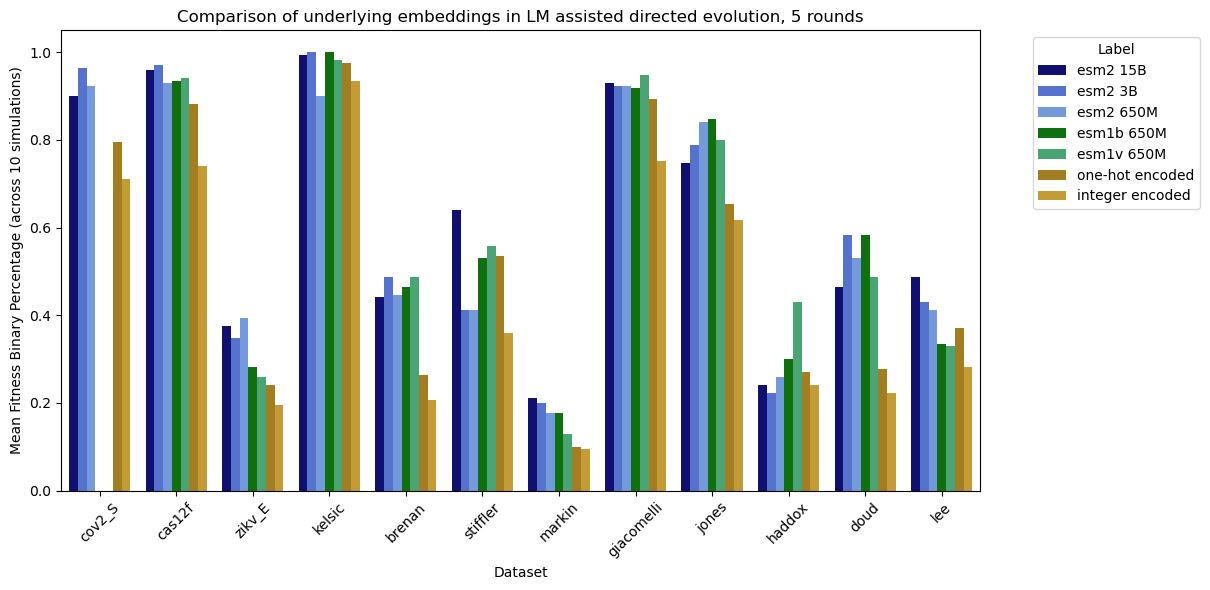

In [18]:
# Define the colors for each hue level
palette_colors = {'esm2 15B': 'navy', 
                  'esm2 3B': 'royalblue', 
                  'esm2 650M': 'cornflowerblue',

                  'esm1b 650M': 'green',
                  'esm1v 650M': 'mediumseagreen',

                  'one-hot encoded': 'darkgoldenrod',
                  'integer encoded': 'goldenrod'}

# Create the bar plot with hue and error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=concatenated_df_5, x='dataset', y='fitness_binary_percentage_mean', hue='label',
            palette=palette_colors)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

# ax.errorbar(x=x_coords, y=y_coords, yerr=concatenated_df["fitness_binary_percentage_std"], fmt="none", capsize=2, c="k")

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of underlying embeddings in LM assisted directed evolution, 5 rounds')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

concatenated_df_5.to_csv("results/5_rounds_results.csv", index=False)

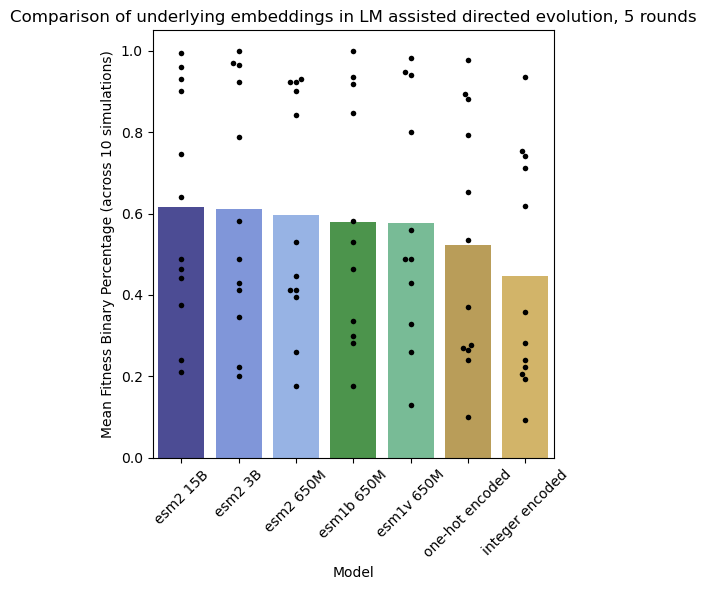

In [19]:
# Define the colors for each hue level
palette_colors = {'esm2 15B': 'navy', 
                  'esm2 3B': 'royalblue', 
                  'esm2 650M': 'cornflowerblue',
                  'esm1b 650M': 'green',
                  'esm1v 650M': 'mediumseagreen',
                  'one-hot encoded': 'darkgoldenrod',
                  'integer encoded': 'goldenrod'}

# Create the bar plot
plt.figure(figsize=(5, 6))
ax = sns.barplot(data=concatenated_df_5, x='label', y='fitness_binary_percentage_mean',
                 palette=palette_colors, errorbar = None, alpha = 0.75)

# Overlay underlying points with jitter
sns.swarmplot(data=concatenated_df_5, x='label', y='fitness_binary_percentage_mean', 
              size=4, color = "black")

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of underlying embeddings in LM assisted directed evolution, 5 rounds')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

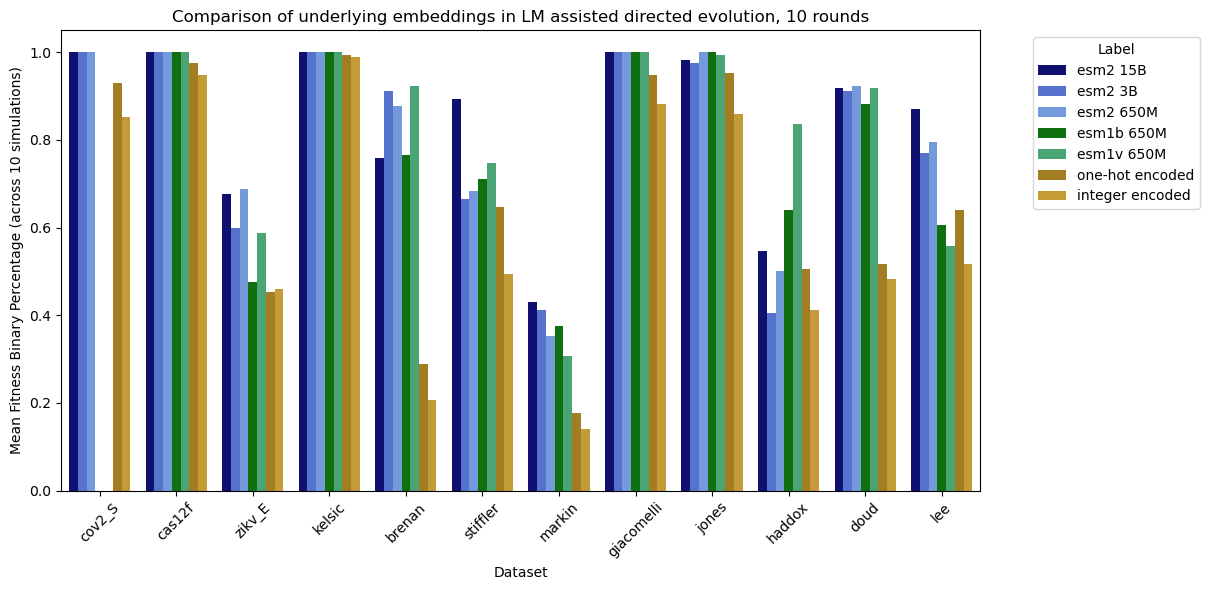

In [20]:
# Define the colors for each hue level
palette_colors = {'esm2 15B': 'navy', 
                  'esm2 3B': 'royalblue', 
                  'esm2 650M': 'cornflowerblue',

                  'esm1b 650M': 'green',
                  'esm1v 650M': 'mediumseagreen',

                  'one-hot encoded': 'darkgoldenrod',
                  'integer encoded': 'goldenrod'}

# Create the bar plot with hue and error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=concatenated_df_10, x='dataset', y='fitness_binary_percentage_mean', hue='label',
            palette=palette_colors)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

# ax.errorbar(x=x_coords, y=y_coords, yerr=concatenated_df["fitness_binary_percentage_std"], fmt="none", capsize=2, c="k")

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of underlying embeddings in LM assisted directed evolution, 10 rounds')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

concatenated_df_10.to_csv("results/10_rounds_results.csv", index=False)

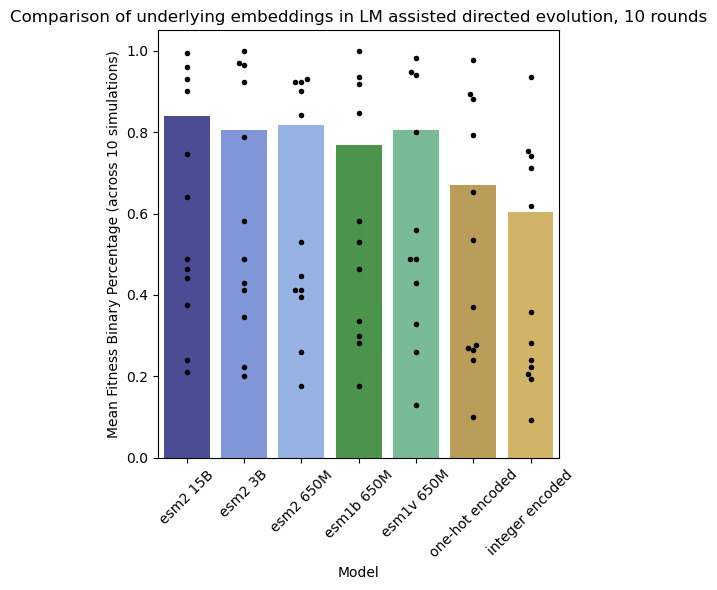

In [21]:
# Define the colors for each hue level
palette_colors = {'esm2 15B': 'navy', 
                  'esm2 3B': 'royalblue', 
                  'esm2 650M': 'cornflowerblue',
                  'esm1b 650M': 'green',
                  'esm1v 650M': 'mediumseagreen',
                  'one-hot encoded': 'darkgoldenrod',
                  'integer encoded': 'goldenrod'}

# Create the bar plot
plt.figure(figsize=(5, 6))
ax = sns.barplot(data=concatenated_df_10, x='label', y='fitness_binary_percentage_mean',
                 palette=palette_colors, errorbar = None, alpha = 0.75)

# Overlay underlying points with jitter
sns.swarmplot(data=concatenated_df_5, x='label', y='fitness_binary_percentage_mean', 
              size=4, color = "black")

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of underlying embeddings in LM assisted directed evolution, 10 rounds')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# make a color map dictionary for datasets
datasets = ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin', "cov2_S", "cas12f", "zikv_E"]
color_map = {dataset: plt.cm.tab20(i) for i, dataset in enumerate(datasets)}

# show the colors of the color map
for dataset in datasets:
    print(dataset, color_map[dataset])

def plot_round_by_round_comparison(df, output_var, ax = None, comparison=False):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Left join the comparison values
    df = left_join_hie(df)

    # Create a color map for datasets
    datasets = df['dataset'].unique()

    # Plot each dataset and embedding type as a separate line
    for i, dataset in enumerate(datasets):
        dataset_df = df[(df['dataset'] == dataset)]
        x_values = dataset_df['round_num']
        y_values = dataset_df[output_var]
        error_values = dataset_df['fitness_binary_percentage_std']
        y_value_min = y_values - error_values
        y_value_max = y_values + error_values
        color = color_map[dataset]  # Corrected line

        # Plot the line with error bars
        ax = sns.lineplot(x=x_values, y=y_values, ax=ax, marker='o', color=color, label=dataset)
        # ax.fill_between(x_values, y_value_min, y_value_max, alpha=0.2)
        # ax.errorbar(x=x_values, y=y_values, yerr=error_values, fmt="none", capsize=2, c="k")

        if comparison:
            comparisons = dataset_df['comparison']
            for k, comparison_value in enumerate(comparisons):
                if not np.isnan(comparison_value):
                    # Create an interpolation function for the line
                    line_interp = interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')
    
                    # Find the intersection point with the comparison value
                    intersection_x = np.interp(comparison_value, y_values, x_values)
                    intersection_y = line_interp(intersection_x)
    
                    # Plot the dash marker at the intersection point
                    ax.scatter(intersection_x, intersection_y, color='black', s=200, marker='_', zorder=5, label='_nolegend_')
    
    # Add labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var.replace('_', ' ').title())
    ax.set_title(f'{output_var.replace("_", " ").title()} by Iterations')
    
    # Show the legend
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Show the plot
    plt.show()

jones (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
stiffler (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)
haddox (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
doud (1.0, 0.7333333333333333, 0.47058823529411764, 1.0)
lee (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
kelsic (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0)
brenan (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
giacomelli (1.0, 0.596078431372549, 0.5882352941176471, 1.0)
markin (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)
cov2_S (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0)
cas12f (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)
zikv_E (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0)


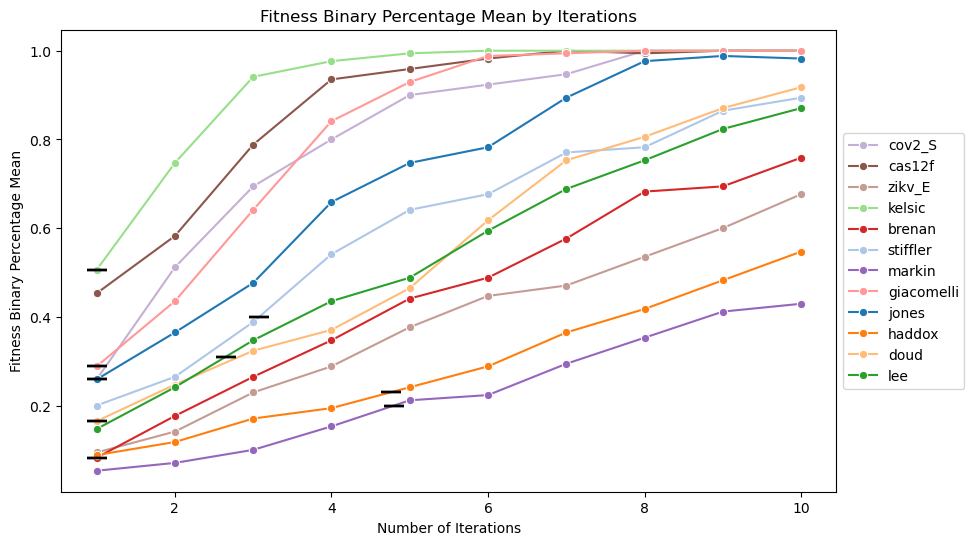

In [23]:
plot_round_by_round_comparison(result_df_rounds, 'fitness_binary_percentage_mean', comparison=True)